# pytorch

In [8]:
# Import packages
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset


# Load data
squat_data = pd.read_csv('squat_data.csv')
up_data = pd.read_csv('up_data.csv')
crunch_data = pd.read_csv('crunch_data.csv')
lunge_data = pd.read_csv('lunge_data.csv')
raise_data = pd.read_csv('raise_data.csv')


sequence_length=200

X_data=[]
X_sequences1=[]
X_sequences2=[]
X_sequences3=[]
X_sequences4=[]
X_sequences5=[]


squat_data_array = squat_data.to_numpy()
up_data_array = up_data.to_numpy()
crunch_data_array = crunch_data.to_numpy()
lunge_data_array = lunge_data.to_numpy()
raise_data_array = raise_data.to_numpy()


# squat
for i in range(len(squat_data_array) - sequence_length + 1):
    X_sequences1.append(squat_data_array[i:i + sequence_length])
y_squat=np.ones(len(X_sequences1))*0


# push-up
for i in range(len(up_data_array) - sequence_length + 1):
    X_sequences2.append(up_data_array[i:i + sequence_length])
y_up=np.ones(len(X_sequences2))*1    


#crunch
for i in range(len(crunch_data_array) - sequence_length + 1):
    X_sequences3.append(crunch_data_array[i:i + sequence_length])
y_crunch=np.ones(len(X_sequences3))*2    


#lunge
for i in range(len(lunge_data_array) - sequence_length + 1):
    X_sequences4.append(lunge_data_array[i:i + sequence_length])
y_lunge=np.ones(len(X_sequences4))*3


#leg raise
for i in range(len(raise_data_array) - sequence_length + 1):
    X_sequences5.append(raise_data_array[i:i + sequence_length])
    
y_raise=np.ones(len(X_sequences5))*4   


X_data = np.concatenate((X_sequences1, X_sequences2,X_sequences3, X_sequences4,X_sequences5), axis=0)
y_data = np.concatenate((y_squat, y_up,y_crunch,y_lunge,y_raise), axis=0)


X_tensor = torch.tensor(X_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.long)


dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out



input_size = 8  
hidden_size = 64  
num_layers = 2  
output_size = 5  

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0134
Epoch [2/10], Loss: 0.0037
Epoch [3/10], Loss: 0.0023
Epoch [4/10], Loss: 0.0018
Epoch [5/10], Loss: 0.0009
Epoch [6/10], Loss: 0.0009
Epoch [7/10], Loss: 0.0007
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0003


Accuracy: 1.0000


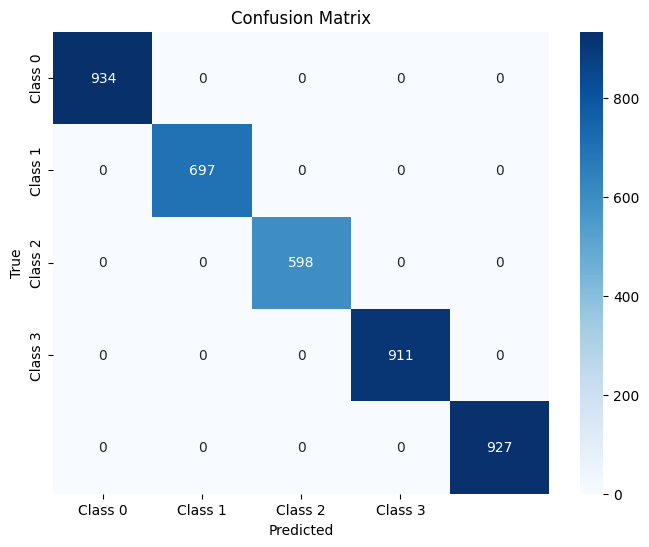

In [10]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())


accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')


cm = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'model/lstm_model.pth')